In [ ]:
import numpy as np
from scipy import optimize
from scipy.stats import norm
import scipy.stats as si
from scipy.sparse import diags
from scipy.linalg import solve_triangular
import matplotlib.pyplot as plt

Write a function which computes the implied volatility $\sigma_{imp}$ given $(S_0, K, r, T, C)$ as input values.

In [ ]:
def impliedvolatilitycall(sigma, s0, K, r, T, C):
  d1 = 1/(sigma*T**0.5) * (np.log(s0/K)+(r+sigma**2)*T)
  d2 = d1 - sigma*T**0.5
  
  return s0*norm.cdf(d1) - norm.cdf(d2)*K*np.exp(-r*T) - C

Fix the initial stock price as $S_0 = 100$ and maturity as $T = 1$ year. Use Finite Difference explicit scheme to compute the prices of European call option over a range of strikes $K \in [70, 130]$ under the local volatility model specified in (1).

In [ ]:
r, T = 0.01, 1
s_min, s_max = 0, 300
N, M = 1000, 120
sigma = np.zeros((N+1, M+1))
dt = T/N
dx = (s_max - s_min)/M
s = np.linspace(s_min, s_max, M+1)
t = np.linspace(0, T, N+1)

for i in range(len(t)):
  for j in range(len(s)):
    sigma[i][j] = (1 + (T - t[i])/30)*(0.1 + 0.4 * np.exp(-s[j]/50))

In [ ]:
# Running the explicit scheme

Ks = range(70, 131, 1)
value_100_local = []
for i in range(len(Ks)):
  # Initial condition
  v_ex = np.maximum(s - Ks[i], 0) # call option payoff

  # Iteration of explicit scheme
  for n in range(1,N+1):

    # Set up the vectors A, B and C
    A = 0.5 * sigma[n]**2 * dt / dx**2 * s**2 - 0.5 * r * dt/ dx * s
    B = - sigma[n]**2 * dt / dx**2 * s**2 - r * dt
    C = 0.5 * sigma[n]**2 * dt / dx**2 * s**2 + 0.5 * r * dt/ dx * s

    # Setup the matrix L and I
    a_diag = np.concatenate([A[1:-1],[0]])
    b_diag = np.concatenate([[0],B[1:-1],[0]])
    c_diag = np.concatenate([[0],C[1:-1]])
    L = diags([a_diag, b_diag, c_diag], [-1, 0, 1]).toarray()
    I = np.identity(M+1)

    v_ex = np.matmul(I+L, v_ex)           # V^{n+1} = (I+L)V^n
    v_ex[0] = 0                           # Boundary operation at s_min
    v_ex[M] = s_max - Ks[i]*np.exp(-r*t[n])   # Boundary operation at s_max
  value_100_local.append(v_ex[list(s).index(100.)])

Plot volatility $\sigma$ against strike $K$.

In [ ]:
s0 = 100
sigmas_implied_local = []

for i in range(len(value_100_local)):
  sigma_implied = optimize.brentq(impliedvolatilitycall, -1, 1, args = (s0, Ks[i], r, T, value_100_local[i]))
  sigmas_implied_local.append(sigma_implied)

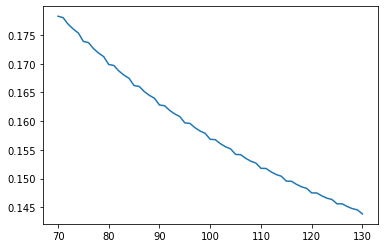

In [ ]:
plt.plot(Ks, sigmas_implied)

Replace the local volatility function by a constant volatility $\sigma(t, s) = 15.7\%$ under Finite Difference Method. 

In [ ]:
# Running the explicit scheme

sigma_c = 0.157
Ks = range(70, 131, 1)
value_100_c = []

# Set up the vectors A, B and C
A = 0.5 * sigma_c**2 * dt / dx**2 * s**2 - 0.5 * r * dt/ dx * s
B = - sigma_c**2 * dt / dx**2 * s**2 - r * dt
C = 0.5 * sigma_c**2 * dt / dx**2 * s**2 + 0.5 * r * dt/ dx * s

# Setup the matrix L and I
a_diag = np.concatenate([A[1:-1],[0]])
b_diag = np.concatenate([[0],B[1:-1],[0]])
c_diag = np.concatenate([[0],C[1:-1]])
L = diags([a_diag, b_diag, c_diag], [-1, 0, 1]).toarray()
I = np.identity(M+1)

for i in range(len(Ks)):
  # Initial condition
  v_ex = np.maximum(s - Ks[i], 0) # call option payoff

  # Iteration of explicit scheme
  for n in range(1,N+1):
    v_ex = np.matmul(I+L, v_ex)           # V^{n+1} = (I+L)V^n
    v_ex[0] = 0                           # Boundary operation at s_min
    v_ex[M] = s_max - Ks[i]*np.exp(-r*t[n])   # Boundary operation at s_max
  value_100_c.append(v_ex[list(s).index(100.)])

In [ ]:
s0 = 100
sigmas_implied_c = []

for i in range(len(value_100_c)):
  sigma_implied = optimize.brentq(impliedvolatilitycall, 0.000001, 1, args = (s0, Ks[i], r, T, value_100_c[i]))
  sigmas_implied_c.append(sigma_implied)

Plot volatility $\sigma$ against strike $K$.

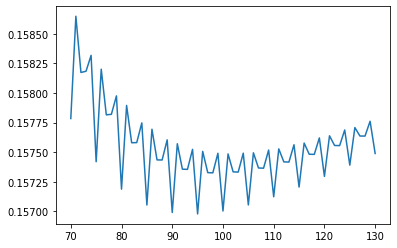

In [ ]:
plt.plot(Ks, sigmas_implied_c)

Price the call option under Black-Sholes Model. Plot volatility $\sigma$ against strike $K$.

In [ ]:
value_100_bs = []
for K in Ks:
  value_100_bs.append(impliedvolatilitycall(sigma_c, s0, K, r, T, 0))

In [ ]:
s0 = 100
sigmas_implied_bs = []

for i in range(len(value_100_bs)):
  sigma_implied = optimize.brentq(impliedvolatilitycall, 0.000001, 1, args = (s0, Ks[i], r, T, value_100_bs[i]))
  sigmas_implied_bs.append(sigma_implied)

(0.156, 0.158)

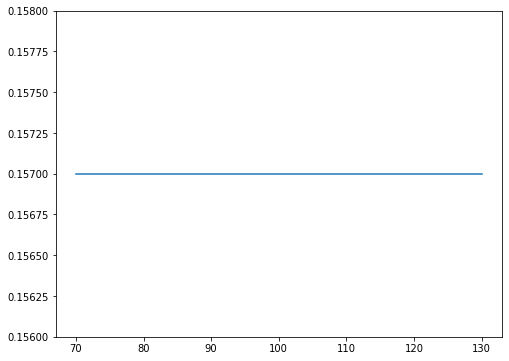

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
plt.plot(Ks, sigmas_implied_bs)
ax.set_ylim((0.156, 0.158))

Plot the difference between option value under finite difference method and Black-Scholes model against strike $K$.

No handles with labels found to put in legend.


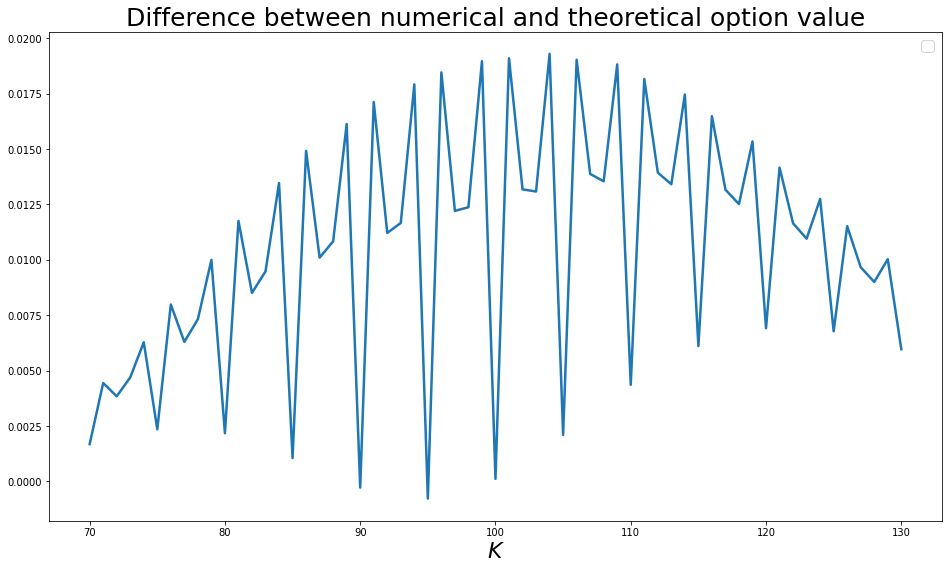

In [ ]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(Ks, np.asarray(value_100_c) - np.asarray(value_100_bs), linewidth=2.5)

ax.set_title("Difference between numerical and theoretical option value", fontsize = 25)
ax.set_xlabel("$K$", fontsize = 22)

ax.legend(fontsize = 16)

We can make an educated guess that the difference between option value under above two methods cause the deviation of implied volatility under finite difference method from that under Black-Sholes model.